<h2 id="toc">목차</h2>

1. [초기 세팅](#contents1)
    1. [라이브러리 불러오기](#contents1-1)
    2. [데이터 로드](#contents1-2)
2. [문제 난이도 예측](#contents2)
    1. [Feature selection](#contents2-1)
    2. [Feature 전처리](#contents2-2)
    3. [Target변수 전처리](#contents2-3)
    4. [모델 학습](#contents2-4)
    5. [모델 및 Target(y) 전처리 방식 선정](#contents2-5)
    6. [특성 중요도 확인](#contents2-6)
    7. [unseen 데이터 테스트](#contents2-7)
    8. [결론 및 향후 개선점](#contents2-8)

<h3 id="contents1">1. 초기 세팅</h3>

[⬆ 목차로](#toc)

---

<h4 id="contents1-1">1-1. 라이브러리 불러오기</h4>

[⬆ 목차로](#toc)

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    KFold
)
from sklearn.linear_model import (
    LinearRegression, 
    Ridge, 
    Lasso, 
    ElasticNet
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import warnings
# 경고메세지 무시
warnings.filterwarnings("ignore")

SEED = 42

<h4 id="contents1-2">1-2. 데이터 로드</h4>

[⬆ 목차로](#toc)

---

In [2]:
df = pd.read_csv('수학시험_데이터_preprocessed.csv', encoding='utf-8-sig')
df.head()

,question_number,answer,difficulty,score,accuracy_rate,option1,option2,option3,option4,option5,subject,exam_date,exam_type,ocr_text_raw,ocr_text_clean,ocr_text_tokens,ocr_has_latex,question_type
0,1,5,하,2,0.91,0.02,0.02,0.02,0.03,0.91,확률과통계,2025-05-08,학력평가,1. \( \left(3^{1-\sqrt{2}}\right)^{2} \times 9...,1. \( \left(3^{1-\sqrt{2}}\right)^{2} \times 9...,"['1', '.', '\\left', '(', '3', '^', '{', '1', ...",True,객관식
1,2,1,하,2,0.91,0.91,0.02,0.02,0.04,0.02,확률과통계,2025-05-08,학력평가,2. 함수 \( f(x)=x^{3}-2 x+5 \) 에 대하여 \( \lim _{h...,2. 함수 \( f(x)=x^{3}-2 x+5 \) 에 대하여 \( \lim _{h...,"['2', '.', '함수', 'f', '(', 'x', ')', '=', 'x',...",True,객관식
2,3,3,중하,3,0.86,0.02,0.03,0.86,0.06,0.02,확률과통계,2025-05-08,학력평가,3. 첫째항과 공비가 모두 양수 \( k \) 인 등비수열 \( \left\{a_{...,3. 첫째항과 공비가 모두 양수 \( k \) 인 등비수열 \( \left\{a_{...,"['3', '.', '첫째', '항', '과', '공비', '가', '모두', '양...",True,객관식
3,4,1,하,3,0.90,0.90,0.03,0.03,0.02,0.01,확률과통계,2025-05-08,학력평가,4. 함수 \( y=f(x) \) 의 그래프가 그림과 같다.\n\( \lim _{x...,4. 함수 \( y=f(x) \) 의 그래프가 그림과 같다.\n\( \lim _{x...,"['4', '.', '함수', 'y', '=', 'f', '(', 'x', ')',...",True,객관식
4,5,4,하,3,0.92,0.01,0.02,0.03,0.92,0.02,확률과통계,2025-05-08,학력평가,5. 함수 \( f(x)=(2 x+1)\left(x^{2}-2 x+5\right) ...,5. 함수 \( f(x)=(2 x+1)\left(x^{2}-2 x+5\right) ...,"['5', '.', '함수', 'f', '(', 'x', ')', '=', '(',...",True,객관식


<h3 id="contents2">2. 문제 정답률 예측</h3>

[⬆ 목차로](#toc)

---

<h4 id="contents2-1">2-1. Feature selection</h4>

[⬆ 목차로](#toc)

---

`정답률` 컬럼에 영향을 줄만한 컬럼들을 Feature로 선택하겠습니다

우선, `difficulty`컬럼은 `정답률`컬럼에 의존하므로 반드시 빼야합니다

그리고 `option1` ~ `option5`의 경우도 포함하면 문제가 될수 있습니다

예를들어 답이 3번인 문제의 경우 `option3`의 비율이 곧 정답률이 됩니다

이와같이 컬럼간의 의존성으로 문제가 될수 있기 때문에 `option1` ~ `option5`도 feature에서 제외시키겠습니다

`answer`, `score`, `subject`, `exam_type`, `exam_date(연/월)`, `ocr_text_clean`길이, `ocr_text_tokens`길이, `ocr_has_latex`, `question_type`

<h4 id="contents2-2">2-2. Feature 전처리</h4>

[⬆ 목차로](#toc)

---

컬럼별 전처리 전략은 다음과 같습니다

| 구분      | Feature                  | 설명                    | 전처리 방식                       |
| ------- | ------------------------ | --------------------- | ----------------------------- |
| **수치형** | `score`                  | 배점 (연속값)              | MinMaxScaler                  |
|         | `ocr_text_clean_length`  | 문제 텍스트 길이             | MinMaxScaler                  |
|         | `ocr_text_tokens_length` | 문제 토큰 길이              | MinMaxScaler                  |
| **범주형** | `answer`                 | 객관식 문제는 1~5, 주관식 문제는 '주관식'으로 값 통일      | 원핫 인코딩                        |
|         | `subject`                | 과목명 (확률과통계, 미적분 등)    | 원핫 인코딩                        |
|         | `exam_type`              | 시험 종류 (학력평가, 수능 등)    | 원핫 인코딩                        |
|         | `exam_date(연/월)`         | 시험 연도/월               | 연=수치형, 월=사이클릭 인코딩 |
|         | `ocr_has_latex`          | 수식 포함 여부 (True/False) | 원핫 인코딩 (또는 binary 0/1)        |
|         | `question_type`          | 문제 유형 (객관식, 서술형 등)    | 원핫 인코딩                        |


feature 선택과 전처리 과정을 함수로 정의하고, X라는 변수에 저장합니다

In [3]:
def prepare_features(
        df: pd.DataFrame,    
        preprocessor= None,  
        fit= True,           
        )-> pd.DataFrame:
    '''
    데이터프레임에서 머신러닝 모델 학습/예측용 feature를 생성하고 전처리합니다.

    Parameters
    ----------
    
    df : pd.DataFrame
        - 입력 데이터프레임 (train/test/unseen)
    preprocessor : ColumnTransformer or None, default=None
        - 이미 학습된 전처리기를 전달할 수 있음.
        - None이면 새로운 전처리기를 생성하여 fit 수행.
    fit : bool, default=True
        - True: train 데이터에서 전처리 기준(fit) 학습
        - False: unseen 데이터에 대해 transform만 수행

    Returns
    -------
    
    feature_df : pd.DataFrame
        - 전처리 및 인코딩이 완료된 feature 데이터프레임
    preprocessor : ColumnTransformer
        - 학습된 전처리기 (unseen 데이터 변환용으로 반환)
    
    Example
    -------
    
    #### train 데이터
        ```python
        X_train, preprocessor = prepare_features(train_df, fit=True)
        ```

    #### unseen 데이터
        ```python
        X_unseen, _ = prepare_features(unseen_df, preprocessor=preprocessor, fit=False)
        ```
    '''
    
    df = df.copy()
    
    # --------------------------------------------------
    # 1. answer 재코딩 (객관식 vs 주관식)
    # --------------------------------------------------
    df['answer_cat'] = df.apply(
        lambda x: str(x['answer']) if x['question_type'] == '객관식' else '주관식', axis=1
    )
    
    # --------------------------------------------------
    # 2. 파생 feature 생성
    # --------------------------------------------------
    # 텍스트 길이
    df['ocr_text_clean_length'] = df['ocr_text_clean'].apply(len)
    df['ocr_text_tokens_length'] = df['ocr_text_tokens'].apply(len)
    
    # 날짜 분리
    df['exam_date'] = pd.to_datetime(df['exam_date'])
    df['exam_year'] = df['exam_date'].dt.year
    df['exam_month'] = df['exam_date'].dt.month
    # day는 의미가 거의 없고 차원만 늘린다고 판단해서 제외시켰습니다
    
    # 사이클릭 인코딩 (month) : 'month'의 순환적 특성 유지 (1월과 12월이 가깝다는 점 반영)
    df['exam_month_sin'] = np.sin(2 * np.pi * df['exam_month'] / 12)
    df['exam_month_cos'] = np.cos(2 * np.pi * df['exam_month'] / 12)
    
    # --------------------------------------------------
    # 3. feature 컬럼 정의
    # --------------------------------------------------
    numeric_features = ['ocr_text_clean_length', 'ocr_text_tokens_length', 'exam_month_sin', 'exam_month_cos']
    categorical_features = ['score', 'answer_cat', 'subject', 'exam_type', 
                            'ocr_has_latex', 'question_type']
    
    # --------------------------------------------------
    # 4. 전처리 파이프라인 생성
    # --------------------------------------------------
    if preprocessor is None:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', MinMaxScaler(), numeric_features),
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
            ]
        )
    
    # --------------------------------------------------
    # 5. 전처리 적용
    # --------------------------------------------------
    if fit:
        feature_processed = preprocessor.fit_transform(df)
    else:
        feature_processed = preprocessor.transform(df)
    
    # --------------------------------------------------
    # 6. 컬럼명 생성 (OneHotEncoder 적용 후)
    # --------------------------------------------------
    numeric_cols = numeric_features
    cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    
    # --------------------------------------------------
    # 7. 최종 DataFrame
    # --------------------------------------------------
    feature_df = pd.DataFrame(feature_processed, columns=list(numeric_cols) + list(cat_cols))
    
    return feature_df, preprocessor

In [4]:
# df에 전처리함수 적용하고 확인
X, preprocessor = prepare_features(df, fit=True)
X

,ocr_text_clean_length,ocr_text_tokens_length,exam_month_sin,exam_month_cos,score_2,score_3,score_4,answer_cat_1,answer_cat_2,answer_cat_3,...,subject_수학(가),subject_수학(나),subject_확률과통계,exam_type_모의평가,exam_type_수능,exam_type_학력평가,ocr_has_latex_False,ocr_has_latex_True,question_type_객관식,question_type_주관식
0,0.017520,0.023909,0.75,0.066987,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.029200,0.036588,0.75,0.066987,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.046271,0.046731,0.75,0.066987,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.037736,0.041478,0.75,0.066987,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.023810,0.031516,0.75,0.066987,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735,0.130279,0.129868,1.00,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4736,0.105121,0.077884,1.00,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4737,0.083558,0.089839,1.00,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4738,0.077269,0.082775,1.00,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


<h4 id="contents2-3">2-3. Target 변수 전처리</h4>

[⬆ 목차로](#toc)

---

타겟변수 `accuracy_rate` 컬럼을 y변수에 저장합니다



In [5]:
y = df.accuracy_rate
y

0       0.91
1       0.91
2       0.86
3       0.90
4       0.92
        ... 
4735    0.25
4736    0.31
4737    0.52
4738    0.65
4739    0.20
Name: accuracy_rate, Length: 4740, dtype: float64

`accuracy_rate` 의 분포를 시각화 해보겠습니다

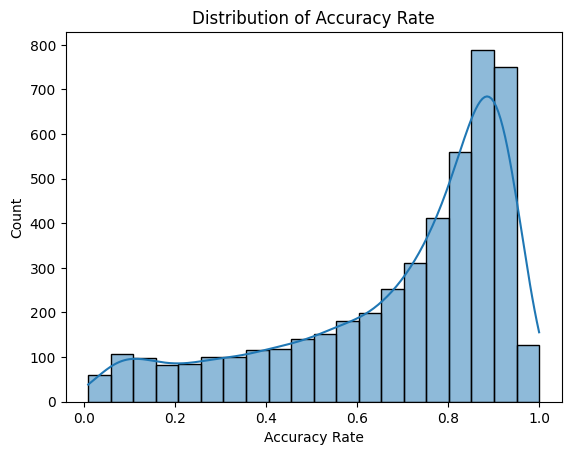

In [6]:
sns.histplot(y, bins=20, kde=True)
plt.xlabel('Accuracy Rate')
plt.title('Distribution of Accuracy Rate')
plt.show()

`accuracy_rate`는 오른쪽으로 편향된 분포를 보여, 스케일링이 필요할 것으로 보입니다.

어떤 스케일러를 사용할지는 확정하기 어려워, 나중에 모델 학습 시 여러 스케일러를 적용해 비교해 보겠습니다.

<h4 id="contents2-4">2-4. 모델 학습</h4>

[⬆ 목차로](#toc)

---

다양한 모델들을 적용해보겠습니다.

- 선형 계열 
    - LinearRegression
    - Ridge
    - Lasso
    - ElasticNet 

- 트리 계열 
    - RandomForestRegressor 
    - GradientBoostingRegressor 
    - XGBRegressor (xgboost) 

- 비선형 계열 
    - SVR (Support Vector Regressor) 
    - MLPRegressor (신경망)

In [7]:
from tqdm import tqdm
# 경고메세지 무시
warnings.filterwarnings("ignore")

# --------------------------------------------------
# 1. y 버전 정의
# --------------------------------------------------
y_raw = y.values           # 원본
y_log = np.log1p(y_raw)    # 로그 변환
scaler_y = MinMaxScaler()  # 0-1 스케일링
y_scaled = scaler_y.fit_transform(y_raw.reshape(-1, 1)).ravel()  # 스케일러 적용 후 1차원 배열로 변환

y_versions = {
    'y_raw': y_raw,
    'y_log': y_log,
    'y_scaled': y_scaled
}

# --------------------------------------------------
# 2. 모델과 하이퍼파라미터 정의
# --------------------------------------------------
models = {
    # 선형 계열
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),

    # 트리 계열
    'RandomForest': RandomForestRegressor(random_state=SEED),
    'GradientBoosting': GradientBoostingRegressor(random_state=SEED),
    'XGB': XGBRegressor(random_state=SEED, eval_metric='rmse'),

    # 비선형
    'SVR': SVR(),
    'MLP': MLPRegressor(random_state=SEED, max_iter=1000)
}

params = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.1, 1.0, 10]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1]},
    'ElasticNet': {'alpha': [0.001, 0.01, 0.1, 1], 'l1_ratio':[0.2,0.5,0.8]},

    'RandomForest': {'n_estimators':[100,200], 'max_depth':[None,10,20]},
    'GradientBoosting': {'n_estimators':[100,200], 'learning_rate':[0.01,0.1], 'max_depth':[3,5]},
    'XGB': {'n_estimators':[100,200], 'learning_rate':[0.01,0.1], 'max_depth':[3,5]},

    'SVR': {'C':[0.1,1,10], 'epsilon':[0.01,0.1]},
    'MLP': {'hidden_layer_sizes':[(50,50),(100,50)], 'alpha':[0.0001,0.001]}
}

# --------------------------------------------------
# 3. GridSearchCV + KFold + Train/Test Split (tqdm 적용)
# --------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
all_results = []


for y_name, y_target in tqdm(y_versions.items(), desc="Y versions"):
    print(f"\n=== Evaluating y version: {y_name} ===\n")
    
    # 80/20 Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.2, random_state=SEED)
    
    for model_name, model in models.items():
        print(f"Running GridSearchCV for {model_name} ...")
        grid = GridSearchCV(model, params[model_name], cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        # 최적 모델로 테스트 세트 평가지표 계산
        best_model = grid.best_estimator_
        y_pred_test = best_model.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae = mean_absolute_error(y_test, y_pred_test)
        r2 = r2_score(y_test, y_pred_test)
        
        all_results.append({
            'y_version': y_name,
            'model': model_name,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'best_params': grid.best_params_
        })
        
        print(f"{model_name} done. RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}\n")

# --------------------------------------------------
# 4. 결과 DataFrame
# --------------------------------------------------
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(['y_version','r2'], ascending=[True, False])
results_df.reset_index(drop=True, inplace=True)
results_df

Y versions:   0%|          | 0/3 [00:00<?, ?it/s]


=== Evaluating y version: y_raw ===

Running GridSearchCV for LinearRegression ...


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

LinearRegression done. RMSE: 0.1457, MAE: 0.1121, R2: 0.6670

Running GridSearchCV for Ridge ...


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Ridge done. RMSE: 0.1459, MAE: 0.1123, R2: 0.6663

Running GridSearchCV for Lasso ...
Lasso done. RMSE: 0.1466, MAE: 0.1125, R2: 0.6631

Running GridSearchCV for ElasticNet ...
ElasticNet done. RMSE: 0.1463, MAE: 0.1125, R2: 0.6646

Running GridSearchCV for RandomForest ...
RandomForest done. RMSE: 0.1191, MAE: 0.0841, R2: 0.7778

Running GridSearchCV for GradientBoosting ...
GradientBoosting done. RMSE: 0.1122, MAE: 0.0789, R2: 0.8026

Running GridSearchCV for XGB ...
XGB done. RMSE: 0.1125, MAE: 0.0786, R2: 0.8017

Running GridSearchCV for SVR ...
SVR done. RMSE: 0.1266, MAE: 0.0874, R2: 0.7489

Running GridSearchCV for MLP ...


Y versions:  33%|███▎      | 1/3 [00:22<00:45, 22.58s/it]

MLP done. RMSE: 0.1248, MAE: 0.0926, R2: 0.7557


=== Evaluating y version: y_log ===

Running GridSearchCV for LinearRegression ...
LinearRegression done. RMSE: 0.0996, MAE: 0.0760, R2: 0.6437

Running GridSearchCV for Ridge ...
Ridge done. RMSE: 0.0997, MAE: 0.0761, R2: 0.6431

Running GridSearchCV for Lasso ...
Lasso done. RMSE: 0.1007, MAE: 0.0762, R2: 0.6359

Running GridSearchCV for ElasticNet ...
ElasticNet done. RMSE: 0.0999, MAE: 0.0761, R2: 0.6415

Running GridSearchCV for RandomForest ...
RandomForest done. RMSE: 0.0793, MAE: 0.0542, R2: 0.7742

Running GridSearchCV for GradientBoosting ...
GradientBoosting done. RMSE: 0.0745, MAE: 0.0501, R2: 0.8008

Running GridSearchCV for XGB ...
XGB done. RMSE: 0.0759, MAE: 0.0509, R2: 0.7932

Running GridSearchCV for SVR ...
SVR done. RMSE: 0.0836, MAE: 0.0557, R2: 0.7491

Running GridSearchCV for MLP ...


Y versions:  67%|██████▋   | 2/3 [00:40<00:20, 20.05s/it]

MLP done. RMSE: 0.0828, MAE: 0.0582, R2: 0.7536


=== Evaluating y version: y_scaled ===

Running GridSearchCV for LinearRegression ...
LinearRegression done. RMSE: 0.1472, MAE: 0.1133, R2: 0.6670

Running GridSearchCV for Ridge ...
Ridge done. RMSE: 0.1474, MAE: 0.1135, R2: 0.6663

Running GridSearchCV for Lasso ...
Lasso done. RMSE: 0.1481, MAE: 0.1136, R2: 0.6632

Running GridSearchCV for ElasticNet ...
ElasticNet done. RMSE: 0.1478, MAE: 0.1137, R2: 0.6646

Running GridSearchCV for RandomForest ...
RandomForest done. RMSE: 0.1204, MAE: 0.0851, R2: 0.7773

Running GridSearchCV for GradientBoosting ...
GradientBoosting done. RMSE: 0.1134, MAE: 0.0798, R2: 0.8026

Running GridSearchCV for XGB ...
XGB done. RMSE: 0.1136, MAE: 0.0794, R2: 0.8017

Running GridSearchCV for SVR ...
SVR done. RMSE: 0.1279, MAE: 0.0883, R2: 0.7488

Running GridSearchCV for MLP ...


Y versions: 100%|██████████| 3/3 [00:56<00:00, 18.90s/it]

MLP done. RMSE: 0.1266, MAE: 0.0910, R2: 0.7536



,y_version,model,rmse,mae,r2,best_params
0,y_log,GradientBoosting,0.074465,0.050056,0.800768,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
1,y_log,XGB,0.075873,0.050944,0.793166,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
2,y_log,RandomForest,0.079270,0.054162,0.774231,"{'max_depth': 10, 'n_estimators': 200}"
3,y_log,MLP,0.082814,0.058191,0.753588,"{'alpha': 0.0001, 'hidden_layer_sizes': (100, ..."
4,y_log,SVR,0.083560,0.055675,0.749132,"{'C': 0.1, 'epsilon': 0.01}"
5,y_log,LinearRegression,0.099579,0.076006,0.643722,{}
6,y_log,Ridge,0.099661,0.076097,0.643139,{'alpha': 0.1}
7,y_log,ElasticNet,0.099895,0.076122,0.641461,"{'alpha': 0.001, 'l1_ratio': 0.2}"
8,y_log,Lasso,0.100665,0.076197,0.635909,{'alpha': 0.001}
9,y_raw,GradientBoosting,0.112208,0.078925,0.802620,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


<h4 id="contents2-5">2-5. 모델 및 Target(y) 전처리 방식 선정</h4>

[⬆ 목차로](#toc)

---

r2스코어가 높은 3개의 모델은 XGB, GradientBoosting, RandomForest 정도인것 같습니다.

이 3개의 평가지표들을 시각화 해보겠습니다

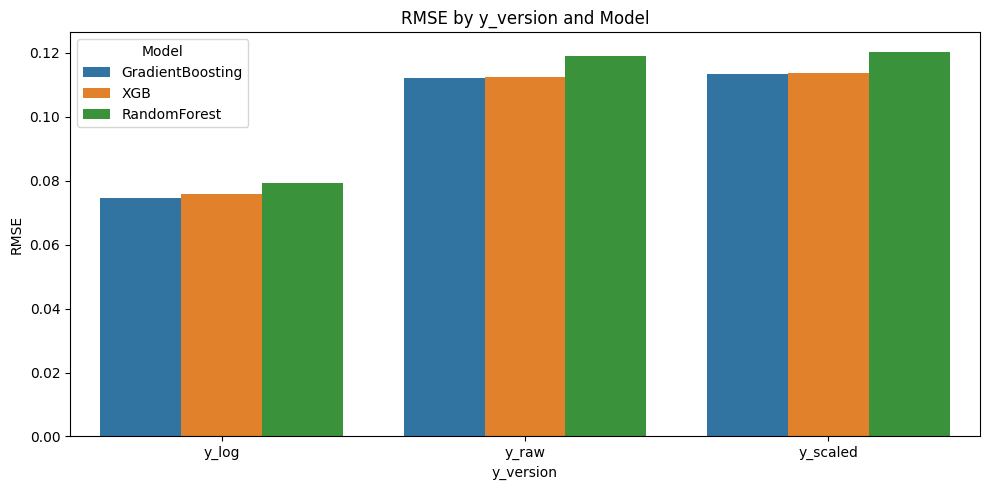

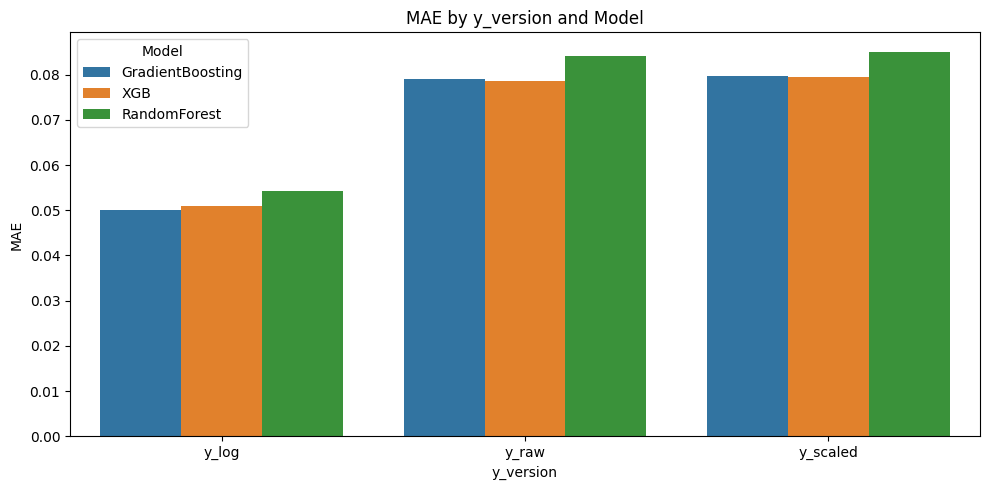

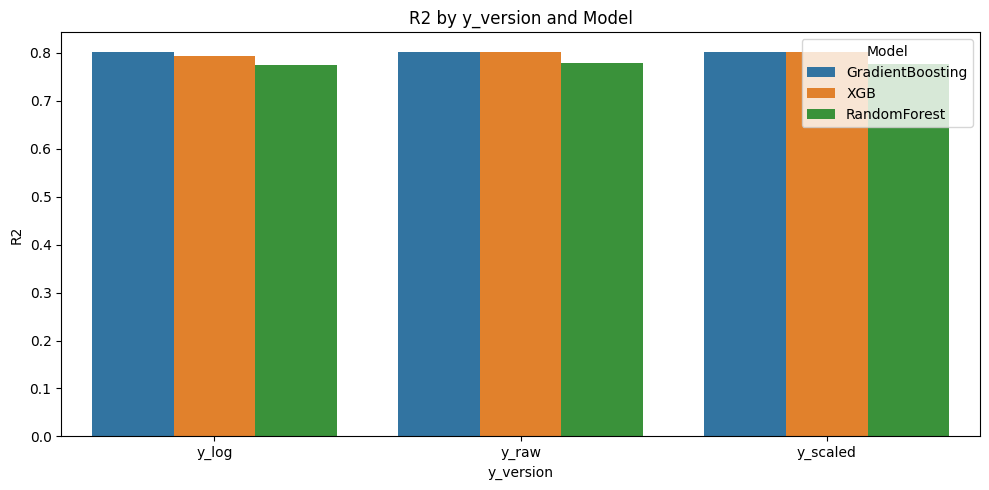

In [8]:
# 사용할 모델 선택
top_models = ['XGB', 'GradientBoosting', 'RandomForest']
metrics = ['rmse', 'mae', 'r2']

# 결과 필터링
plot_df = results_df[results_df['model'].isin(top_models)]

# y_version별로 다중 막대 그래프 그리기
for metric in metrics:
    plt.figure(figsize=(10,5))
    sns.barplot(
        data=plot_df,
        x='y_version',
        y=metric,
        hue='model'
    )
    plt.title(f'{metric.upper()} by y_version and Model')
    plt.ylabel(metric.upper())
    plt.xlabel('y_version')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

MAE, RMSE값이 높고, r2 score는 낮은 RandomForest는 성능이 떨어지므로 제외시키겠습니다.

남은 두개의 모델만 비교해보겠습니다


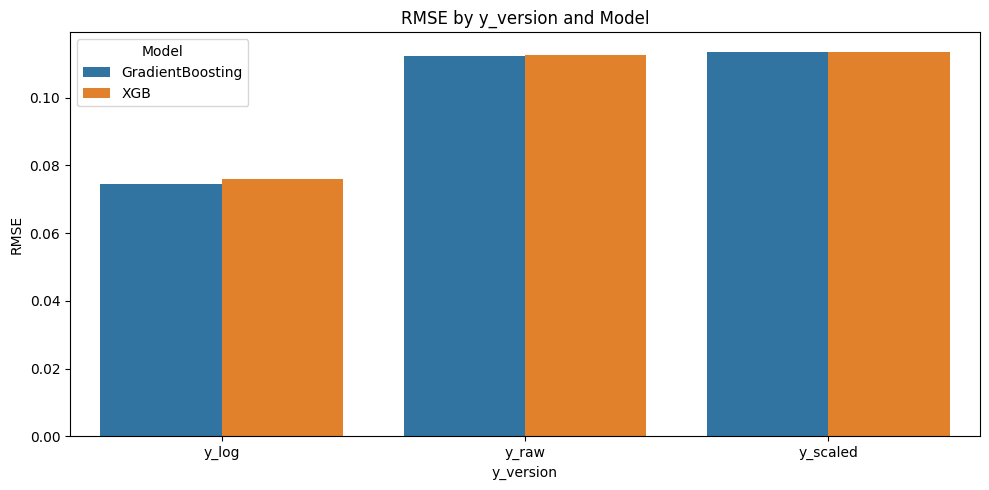

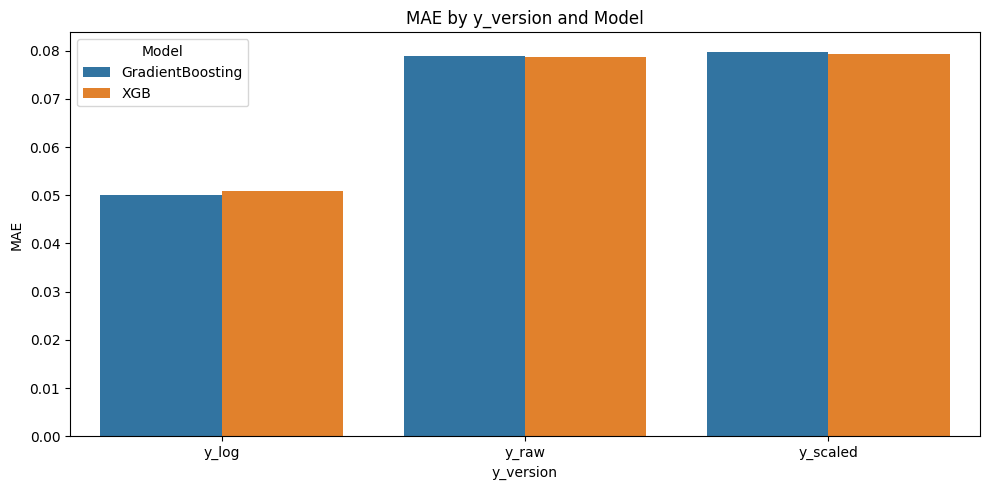

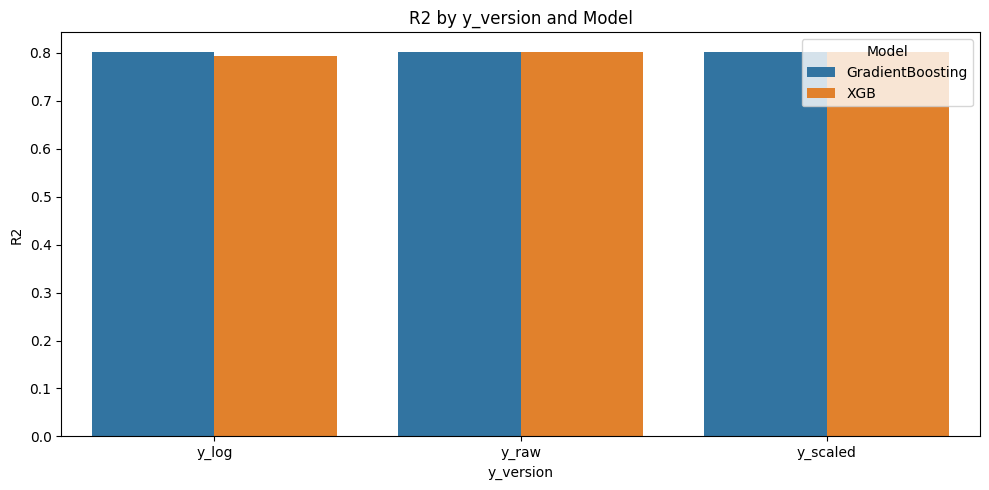

In [9]:
top_models = ['XGB', 'GradientBoosting']
metrics = ['rmse', 'mae', 'r2']

# 결과 필터링
plot_df = results_df[results_df['model'].isin(top_models)]

# y_version별로 다중 막대 그래프 그리기
for metric in metrics:
    plt.figure(figsize=(10,5))
    sns.barplot(
        data=plot_df,
        x='y_version',
        y=metric,
        hue='model'
    )
    plt.title(f'{metric.upper()} by y_version and Model')
    plt.ylabel(metric.upper())
    plt.xlabel('y_version')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

타겟 전처리 방식은 loss가 눈에 띄게 적은 y_log를 선택하겠습니다

마지막으로 XGB와 GradientBoosting를 비교해보겠습니다

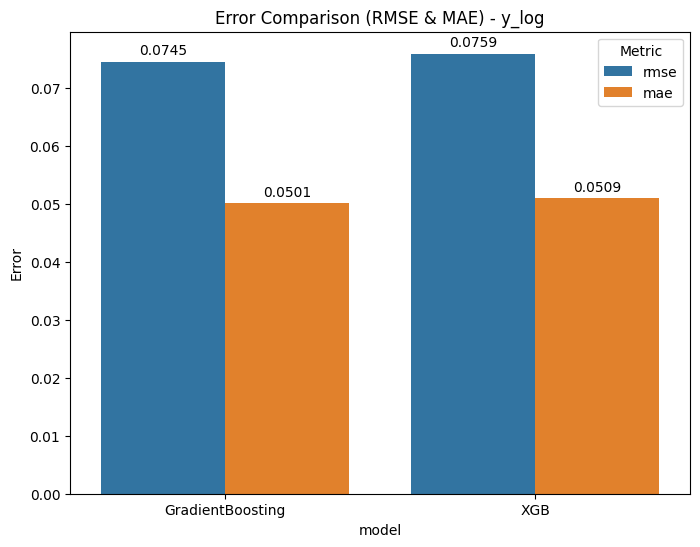

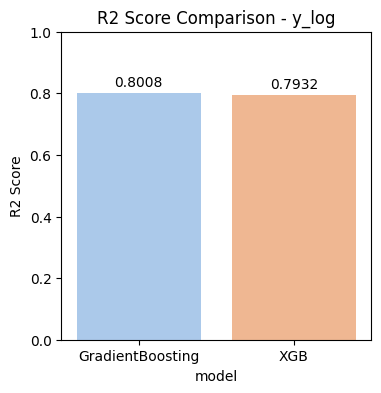

In [10]:
# y_log와 두 모델만 선택
plot_df = results_df[(results_df['y_version']=='y_log') & 
                     (results_df['model'].isin(['XGB','GradientBoosting']))]

# --------------------------------------------------
# 1. Error (RMSE + MAE) 비교
# --------------------------------------------------
error_df = plot_df.melt(id_vars='model', value_vars=['rmse','mae'],
                        var_name='Metric', value_name='Score')

plt.figure(figsize=(8,6))
ax = sns.barplot(data=error_df, x='model', y='Score', hue='Metric')

# 막대 위에 값 표시
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f"{p.get_height():.4f}", 
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0,3), textcoords='offset points')

plt.title("Error Comparison (RMSE & MAE) - y_log")
plt.ylabel("Error")
plt.show()

# --------------------------------------------------
# 2. R2 비교
# --------------------------------------------------
plt.figure(figsize=(4,4))
ax2 = sns.barplot(data=plot_df, x='model', y='r2', palette='pastel')

# 막대 위에 값 표시
for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.4f}",
                 (p.get_x() + p.get_width()/2., p.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black', xytext=(0,3), textcoords='offset points')

plt.title("R2 Score Comparison - y_log")
plt.ylabel("R2 Score")
plt.ylim(0,1)
plt.show()

- RMSE와 MAE(오차)는 GradientBoosting이 약간 낮음

- R²(설명력)도 GradientBoosting이 조금 더 높음

➡ 최종 선택: `GradientBoosting` 모델, `y_log` 적용

GridSearchCV로 생성한 `all_results`에서 최종 선택 모델의 정보들을 추출합니다

In [11]:
filtered = [d for d in all_results 
            if d['y_version'] == 'y_log' and d['model'] == 'GradientBoosting']

filtered[0]

{'y_version': 'y_log',
 'model': 'GradientBoosting',
 'rmse': np.float64(0.07446535553266045),
 'mae': 0.05005565630144633,
 'r2': 0.8007681166146248,
 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}}

모델 정보를 기반으로 GradientBoosting을 새롭게 정의하고 학습시켜줍니다

In [12]:
# 1. GradientBoostingRegressor 객체 생성 (튜닝된 하이퍼파라미터 적용)
final_model = GradientBoostingRegressor(
    **filtered[0]['best_params'],
    random_state=SEED
)

# 2. 타겟 로그 변환
y_train_log = np.log1p(y)

# 3. 모델 학습
final_model.fit(X, y_train_log)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


<h4 id="contents2-6">2-6. 특성 중요도 확인</h4>

[⬆ 목차로](#toc)

---

각 feature가 정답률 예측에 얼마나 기여하는지 중요도를 출력해봅시다.

In [14]:
feat_importances = pd.Series(
    final_model.feature_importances_, 
    index = X_train.columns
)
feat_importances = feat_importances.sort_values(ascending=False)
feat_importances

score_4                   0.492661
question_type_주관식         0.113645
ocr_text_tokens_length    0.097810
ocr_text_clean_length     0.076468
question_type_객관식         0.063574
subject_확률과통계             0.044305
answer_cat_주관식            0.044060
subject_수학(가)             0.016923
exam_month_sin            0.013053
exam_month_cos            0.007250
subject_수학(나)             0.005859
score_3                   0.003514
subject_기하                0.002878
subject_미적분               0.002548
answer_cat_2              0.002480
answer_cat_1              0.001869
score_2                   0.001846
answer_cat_3              0.001669
exam_type_학력평가            0.001316
exam_type_수능              0.001209
ocr_has_latex_False       0.001193
answer_cat_4              0.001080
answer_cat_5              0.000963
ocr_has_latex_True        0.000916
exam_type_모의평가            0.000909
dtype: float64

- `배점`: `정답률` 분류에 **가장 큰 영향**을 미친 주요 Feature (약 0.5)
- `문제유형`: 약 `0.1` 수준의 기여도  
  - 주관식/객관식 여부가 정답률에 **약간의 영향**을 주는 것으로 해석됨

<h4 id="contents2-7">2-7. unseen 데이터 테스트</h4>

[⬆ 목차로](#toc)

---

모델 학습이나 평가에 사용되지 않은 최신 시험 데이터(출처: 메가스터디) 중, 한 문제를 선택했습니다.

2025년 7월 10일 고3 학력평가 기하 14번 문제(실제 난이도: 중상) 채점 결과를 사용하여 테스트를 진행합니다.

메가스터디 페이지에서 추출한 데이터는 다음과 같습니다.

| 번호 | 정답 | 난이도 | 배점 | 정답률 | 선지1 | 선지2 | 선지3 | 선지4 | 선지5 |
|------|------|--------|------|--------|-------|-------|-------|-------|-------|
| 14   | 2    | 중상     | 4    | 57%    | 10%   | 57%   | 9%   | 13%    | 11%    |

정답률 예측을 위해 `정답률`과, 이미 `정답률`에 의존하는 `난이도`는 제외합니다.

In [31]:
sample = {
    "question_number": [14],
    "answer": [2],                  
    "difficulty": ['중상'],
    "score": [4],                    
    "accuracy_rate": 0.57,
    'option1':0.10,
    'option2':0.57,
    'option3':0.09,
    'option4':0.13,
    'option5':0.11,
    "subject": ["기하"], 
    "exam_date": ["2025-07-10"],
    "exam_type": ["학력평가"],
    'ocr_text_raw': ['''
                    14. 그림과 같이 반지름의 길이가 \( 3\sqrt{2} \)인 원 \( O \)의 외부에 있는 점 \( A \)에서 원 \( O \)에 그은 두 접선을 각각 \( l, m \)이라 하고, 두 직선 \( l, m \)이 원 \( O \)와 만나는 점을 각각 \( B, C \)라 하자.  
                    점 \( B \)를 지나고 직선 \( l \)에 수직인 직선이 원 \( O \)와 만나는 두 점 중에서 \( B \)가 아닌 점을 \( P \), 직선 \( AP \)가 원 \( O \)와 만나는 두 점 중에서 \( P \)가 아닌 점을 \( Q \)라 하면 \( \overline{AB}=12 \)일 때,  
                    \( \sin(\angle BPQ) : \sin(\angle QPC) = 3:1 \)이다.  
                    삼각형 \( BQC \)의 넓이는? [4점]
                    (1) \( \tfrac{14\sqrt{2}}{3} \)
                    (2) \( \tfrac{16\sqrt{2}}{3} \)
                    (3) \( 6\sqrt{2} \)
                    (4) \( \tfrac{20\sqrt{2}}{3} \)
                    (5) \( \tfrac{22\sqrt{2}}{3} \)
                    '''],
    "ocr_text_clean":  ['''
                       14. 그림과 같이 반지름의 길이가 \( 3\sqrt{2} \)인 원 \( O \)의 외부에 있는 점 \( A \)에서 원 \( O \)에 그은 두 접선을 각각 \( l, m \)이라 하고, 두 직선 \( l, m \)이 원 \( O \)와 만나는 점을 각각 \( B, C \)라 하자.  
                        점 \( B \)를 지나고 직선 \( l \)에 수직인 직선이 원 \( O \)와 만나는 두 점 중에서 \( B \)가 아닌 점을 \( P \), 직선 \( AP \)가 원 \( O \)와 만나는 두 점 중에서 \( P \)가 아닌 점을 \( Q \)라 하면 \( \overline{AB}=12 \)일 때,  
                        \( \sin(\angle BPQ) : \sin(\angle QPC) = 3:1 \)이다.  
                        삼각형 \( BQC \)의 넓이는? [4점]
                       '''],  
    "ocr_text_tokens": [['14', '.', '그림', '과', '같이', '반지름', '의', '길이', '가', '3', '\\sqrt', '{', '2', '}', '인', '원', 'O', '의', '외부', '에', '있', '는', '점', 'A', '에서', '원', 'O', '에', '그', '은', '두', '접선', '을', '각각', 'l', 'm', '이', '라', '하', '고', ',', '두', '직선', 'l', 'm', '이', '원', 'O', '와', '만나', '는', '점', '을', '각각', 'B', 'C', '라', '하', '자', '.', '점', 'B', '를', '지나', '고', '직선', 'l', '에', '수직', '인', '직선', '이', '원', 'O', '와', '만나', '는', '두', '점', '중', '에서', 'B', '가', '아닌', '점', '을', 'P', ',', '직선', 'AP', '가', '원', 'O', '와', '만나', '는', '두', '점', '중', '에서', 'P', '가', '아닌', '점', '을', 'Q', '라', '하', '면', '\\overline', '{', 'AB', '}', '=', '12', '일', '때', ',', '\\sin', '(', 'ngle', 'BPQ', ')', '\\sin', '(', 'ngle', 'QPC', ')', '=', '3', '1', '이', '다', '.', '삼각형', 'BQC', '의', '넓이', '는', '?', '[', '4', '점', ']']], 
    "ocr_has_latex": [True],          
    "question_type": ["객관식"],      
}

unseen_y = sample['accuracy_rate']
unseen_df = pd.DataFrame(sample)
unseen_df

,question_number,answer,difficulty,score,accuracy_rate,option1,option2,option3,option4,option5,subject,exam_date,exam_type,ocr_text_raw,ocr_text_clean,ocr_text_tokens,ocr_has_latex,question_type
0,14,2,중상,4,0.57,0.1,0.57,0.09,0.13,0.11,기하,2025-07-10,학력평가,\n 14. 그림과 같이 반지름의 길이가 \( 3...,\n 14. 그림과 같이 반지름의 길이가 \...,"[14, ., 그림, 과, 같이, 반지름, 의, 길이, 가, 3, \sqrt, {,...",True,객관식


sample 데이터에 `prepare_features()` 함수를 적용하여 feature 전처리와 스케일링을 수행합니다.

In [32]:
unseen_features, _ = prepare_features(
    unseen_df,
    preprocessor= preprocessor,
    fit= False
)
unseen_features

,ocr_text_clean_length,ocr_text_tokens_length,exam_month_sin,exam_month_cos,score_2,score_3,score_4,answer_cat_1,answer_cat_2,answer_cat_3,...,subject_수학(가),subject_수학(나),subject_확률과통계,exam_type_모의평가,exam_type_수능,exam_type_학력평가,ocr_has_latex_False,ocr_has_latex_True,question_type_객관식,question_type_주관식
0,0.224618,0.011592,0.25,0.066987,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


`final_model`을 사용하여 `unseen_features`에 대한 예측을 수행합니다.

In [40]:
unseen_predict = final_model.predict(unseen_features)
print(f"모델의 unseen 예측값: {unseen_predict[0]:.4f}")
print(f"실제 unseen 값: {unseen_y}")
print(f"오차: {np.abs(unseen_predict[0] - unseen_y):.4f}")

모델의 unseen 예측값: 0.0794
실제 unseen 값: 0.57
오차: 0.4906


unseen 데이터 예측 결과, 실제값과 차이가 있었으며, 이는 모델이 일부 feature에 과도하게 의존했기 때문으로 판단됩니다.

<h4 id="contents2-8">2-8. 결론 및 향후 개선점</h4>

[⬆ 목차로](#toc)

---

본 프로젝트에서는 시험 문제별 정답률(0~1)을 예측하기 위해 다양한 feature를 활용한 회귀 모델을 설계하고 학습하였습니다. 

주요 feature로는 score, question_type, 문항 text 길이, 시험과목 등이 포함되었으며, 

범주형 변수는 원핫 인코딩을 적용하여 모델이 특정 값에 과도하게 의존하지 않도록 조정하였습니다.

모델 학습 결과, train/test 기준에서는 R² 0.80 정도의 성능을 확인하였으나, unseen 데이터에서는 예측값이 실제값보다 낮게 나오는 현상이 관찰되었습니다. 

이는 unseen 데이터의 feature 분포가 train 데이터와 다르거나, score 및 text 기반 feature만으로는 충분한 일반화를 확보하기 어려운 점 때문으로 판단됩니다.

향후 개선 방안으로는 다음과 같은 접근이 가능합니다:
- text feature 강화 (TF-IDF, 단어 임베딩, 키워드 기반 파생 feature 등)
- 모델 구조 조정 및 규제 튜닝
- unseen 데이터 분포를 고려한 feature 스케일링 재조정

이번 프로젝트는 제한된 feature로 예측을 시도하였으며, 향후 확장 가능한 기반을 마련했다는 점에서 의미가 있습니다.
